# Rare Occupation Classification

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from binarycontexttransformer import BinaryContextTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
def show_preds(df, X, y, clf, occupations, duplicates=False):
    df = df.copy()
    df["pred"] = [occupations[code] for code in clf.predict(X)]
    df["proba"] = clf.predict_proba(X).max(axis=1)
    df["correct"] = df["pred"] == df["occupation"]
    if not duplicates:
        df = df.drop_duplicates()
    acc = accuracy_score(df["occupation"], df["pred"])
    pred_df = df[["correct", "occupation", "pred", "proba", "jobtitle", "industry"]]
    out = pred_df.style.apply(lambda row: [
        "background: mediumspringgreen;" if row["pred"] is row["occupation"] else "background: tomato;" for cell in row
    ], axis=1, subset=["occupation", "pred"])
    print("Accuracy = {:.3f}".format(acc))
    return out


def show_weights(clf, features, occupations, ax=None):
    has_plot = True
    if ax is None:
        _, ax = plt.subplots(1, 1)
        has_plot = False
    weights = np.flipud(np.hstack([clf.intercept_.reshape(-1, 1), clf.coef_]).T)
    classes = [occupations[code] for code in clf.classes_]
    predictors = ["intercept"] + features
    class_labels = ["\n".join(c.split(" ")) for c in classes]
    sns.heatmap(weights, annot=True, fmt=".3f", cmap="RdBu", ax=ax)
    ax.set_xticks(np.arange(len(classes)) + 0.5)
    ax.set_yticks(np.arange(len(predictors)) + 0.5)
    ax.set_xticklabels(class_labels, {"rotation": 0})
    ax.set_yticklabels(predictors, {"rotation": 0})
    ax.set_xlabel("Target Class")
    ax.set_ylabel("Predictor Variable")
    ax.set_title("Model Weights")
    if not has_plot:
        plt.show()

    
def show_matrix(X, labels, features, occupations, duplicates=False):
    out = pd.DataFrame(X.todense(), columns=features, index=labels)
    if not duplicates:
        out = out.drop_duplicates()
        return out

In [3]:
fields = ["occupation", "code", "jobtitle", "industry"]

occupations = {
    "27-3021": "Broadcast News Analysts",
    "13-2051": "Financial Analysts",
    "15-1121": "Computer Systems Analysts",
    "13-2011": "Accountants and Auditors",
    "15-1132": "Software Developers, Applications",
    "27-3022": "Reporters and Correspondents"
}

data = [
    ("13-2051", "financial analyst", "finance"),
    ("13-2051", "financial analyst", "finance"),
    ("27-3021", "news analyst", "news"),
    ("27-3021", "news analyst", "news"),
    ("15-1121", "computer analyst", "tech"),
    ("15-1121", "computer analyst", "tech"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
]

data_validate = [
    ("15-1121", "analyst", "tech"),
    ("27-3021", "analyst", "news"),
    ("13-2051", "analyst", "finance"),
]

In [4]:
df = pd.DataFrame(data, columns=["code", "jobtitle", "industry"])
df["occupation"] = df["code"].apply(lambda code: occupations[code])
pd.DataFrame(df.groupby(fields).size().reset_index().values, columns=fields + ["count"])

,occupation,code,jobtitle,industry,count
0,Accountants and Auditors,13-2011,accountant,finance,7
1,Broadcast News Analysts,27-3021,news analyst,news,2
2,Computer Systems Analysts,15-1121,computer analyst,tech,2
3,Financial Analysts,13-2051,financial analyst,finance,2
4,Reporters and Correspondents,27-3022,reporter,news,7
5,"Software Developers, Applications",15-1132,developer,tech,7


In [5]:
df_validate = pd.DataFrame(data_validate, columns=["code", "jobtitle", "industry"])
df_validate["occupation"] = df_validate["code"].apply(lambda code: occupations[code])
df_validate[fields]

,occupation,code,jobtitle,industry
0,Computer Systems Analysts,15-1121,analyst,tech
1,Broadcast News Analysts,27-3021,analyst,news
2,Financial Analysts,13-2051,analyst,finance


## 1. Basic Model

Only uses job title words and industry as predictors.

In [6]:
jobtitle_vectorizer = CountVectorizer(analyzer="word", binary=True)
industry_vectorizer = CountVectorizer(analyzer="word", binary=True)
X_jobtitle = jobtitle_vectorizer.fit_transform(df["jobtitle"])
X_industry = industry_vectorizer.fit_transform(df["industry"])
X_basic = sp.sparse.hstack([X_jobtitle, X_industry])
y = df["code"]

features_jobtitle = ["job_" + f for f in jobtitle_vectorizer.get_feature_names()]
features_industry = ["ind_" + f for f in industry_vectorizer.get_feature_names()]
features_basic = features_jobtitle + features_industry

clf_basic = LogisticRegression(solver="lbfgs", multi_class="multinomial", fit_intercept=True)
clf_basic.fit(X_basic, y)
y_basic = clf_basic.predict(X_basic)

### 1.1. Basic Model Matrix

In [7]:
print("{} features in `term` matrix".format(X_basic.shape[1]))
print("{} features from `jobtitle`".format(X_jobtitle.shape[1]))
print("{} features from `industry`".format(X_industry.shape[1]))
show_matrix(X_basic, df["jobtitle"].values, features_basic, occupations)

10 features in `term` matrix
7 features from `jobtitle`
3 features from `industry`


,job_accountant,job_analyst,job_computer,job_developer,job_financial,job_news,job_reporter,ind_finance,ind_news,ind_tech
financial analyst,0,1,0,0,1,0,0,1,0,0
news analyst,0,1,0,0,0,1,0,0,1,0
computer analyst,0,1,1,0,0,0,0,0,0,1
accountant,1,0,0,0,0,0,0,1,0,0
reporter,0,0,0,0,0,0,1,0,1,0
developer,0,0,0,1,0,0,0,0,0,1


### 1.2. Basic Model Predictions

In [8]:
show_preds(df, X_basic, y, clf_basic, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Financial Analysts,Financial Analysts,0.545106,financial analyst,finance
2,True,Broadcast News Analysts,Broadcast News Analysts,0.545106,news analyst,news
4,True,Computer Systems Analysts,Computer Systems Analysts,0.545106,computer analyst,tech
6,True,Accountants and Auditors,Accountants and Auditors,0.822282,accountant,finance
13,True,Reporters and Correspondents,Reporters and Correspondents,0.822282,reporter,news
20,True,"Software Developers, Applications","Software Developers, Applications",0.822282,developer,tech


In [9]:
X_jobtitle_validate = jobtitle_vectorizer.transform(df_validate["jobtitle"])
X_industry_validate = industry_vectorizer.transform(df_validate["industry"])
X_basic_validate = sp.sparse.hstack([
    X_jobtitle_validate,
    X_industry_validate,
])
show_preds(df_validate, X_basic_validate, y, clf_basic, occupations)

Accuracy = 0.000


,correct,occupation,pred,proba,jobtitle,industry
0,False,Computer Systems Analysts,"Software Developers, Applications",0.325774,analyst,tech
1,False,Broadcast News Analysts,Reporters and Correspondents,0.325774,analyst,news
2,False,Financial Analysts,Accountants and Auditors,0.325774,analyst,finance


### 1.3. Basic Model Weights

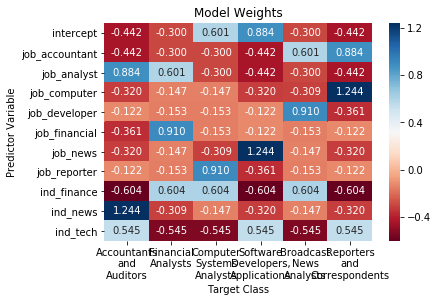

In [10]:
show_weights(clf_basic, features_basic, occupations)

## 2. Context Model

Adds two-way interaction terms between job title words and industry.

In [11]:
help(BinaryContextTransformer)

Help on class BinaryContextTransformer in module binarycontexttransformer:

class BinaryContextTransformer(sklearn.base.TransformerMixin)
 |  Expands base features into interaction terms when they appear with
 |  different context features. Both base features and context features
 |  must be binary.
 |  
 |  Method resolution order:
 |      BinaryContextTransformer
 |      sklearn.base.TransformerMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, features, contexts, progress=None)
 |      Args:
 |          features: names of base features
 |          contexts: names of context features
 |          progress: function of format progress_fn(iter, total) that takes
 |              an iterable and an integer with the total number of items and
 |              returns a generator to track progress at each step of the
 |              iterable (default=None)
 |  
 |  fit(self, X, X_context)
 |      Args:
 |          X: matrix of base feature columns
 |         

In [12]:
bct = BinaryContextTransformer(
    features=features_jobtitle,
    contexts=features_industry
)
X_jobtitle_industry = bct.fit_transform(X_jobtitle, X_industry)
X_context = sp.sparse.hstack([X_jobtitle, X_industry, X_jobtitle_industry])
features_context = features_basic + bct.get_feature_names()

clf_context = LogisticRegression(solver="lbfgs", multi_class="multinomial", fit_intercept=True)
clf_context.fit(X_context, y)
y_context = clf_context.predict(X_context)

### 2.1. Context Model Matrix

In [13]:
print("{} features in `context` matrix".format(X_context.shape[1]))
print("{} features from `jobtitle`".format(X_jobtitle.shape[1]))
print("{} features from `industry`".format(X_industry.shape[1]))
print("{} features from `jobtitle_x_industry`".format(X_jobtitle_industry.shape[1]))
show_matrix(X_context, df["jobtitle"].values, features_context, occupations)

13 features in `context` matrix
7 features from `jobtitle`
3 features from `industry`
3 features from `jobtitle_x_industry`


,job_accountant,job_analyst,job_computer,job_developer,job_financial,job_news,job_reporter,ind_finance,ind_news,ind_tech,ind_finance_x_job_analyst,ind_news_x_job_analyst,ind_tech_x_job_analyst
financial analyst,0,1,0,0,1,0,0,1,0,0,1,0,0
news analyst,0,1,0,0,0,1,0,0,1,0,0,1,0
computer analyst,0,1,1,0,0,0,0,0,0,1,0,0,1
accountant,1,0,0,0,0,0,0,1,0,0,0,0,0
reporter,0,0,0,0,0,0,1,0,1,0,0,0,0
developer,0,0,0,1,0,0,0,0,0,1,0,0,0


### 2.2. Context Model Predictions

In [14]:
show_preds(df, X_context, y, clf_context, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Financial Analysts,Financial Analysts,0.628344,financial analyst,finance
2,True,Broadcast News Analysts,Broadcast News Analysts,0.628344,news analyst,news
4,True,Computer Systems Analysts,Computer Systems Analysts,0.628344,computer analyst,tech
6,True,Accountants and Auditors,Accountants and Auditors,0.830019,accountant,finance
13,True,Reporters and Correspondents,Reporters and Correspondents,0.830019,reporter,news
20,True,"Software Developers, Applications","Software Developers, Applications",0.830019,developer,tech


In [15]:
X_jobtitle_validate = jobtitle_vectorizer.transform(df_validate["jobtitle"])
X_industry_validate = industry_vectorizer.transform(df_validate["industry"])
X_context_validate = sp.sparse.hstack([
    X_jobtitle_validate,
    X_industry_validate,
    bct.transform(X_jobtitle_validate, X_industry_validate)
])
show_preds(df_validate, X_context_validate, y, clf_context, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Computer Systems Analysts,Computer Systems Analysts,0.399234,analyst,tech
1,True,Broadcast News Analysts,Broadcast News Analysts,0.399234,analyst,news
2,True,Financial Analysts,Financial Analysts,0.399234,analyst,finance


### 2.3. Context Model Weights

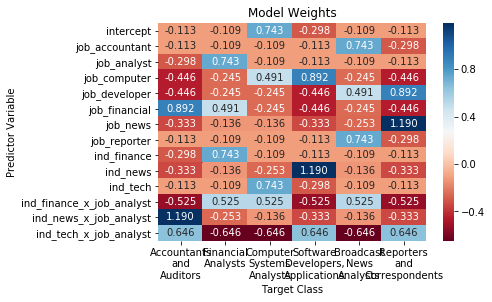

In [16]:
show_weights(clf_context, features_context, occupations)

### 2.4 Comparison of Model Weights

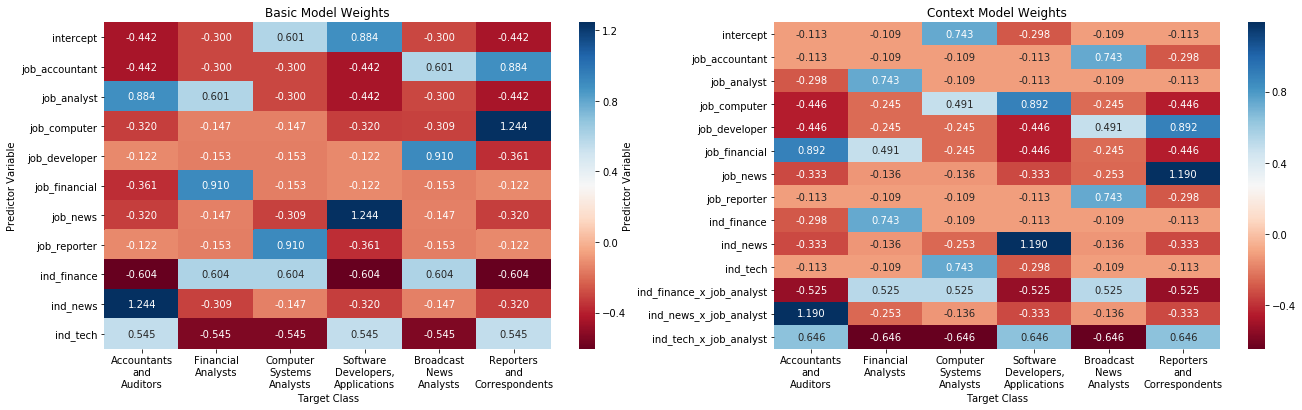

In [17]:
fig, axes = plt.subplots(1, 2)
show_weights(clf_basic, features_basic, occupations, ax=axes[0])
show_weights(clf_context, features_context, occupations, ax=axes[1])
axes[0].set_title("Basic Model Weights")
axes[1].set_title("Context Model Weights")
fig.set_size_inches((22, 6))
plt.show()